In [5]:
]activate .

  Activating environment at `~/qrot_graph/script/Project.toml`


In [6]:
]add ~/OptimalTransport.jl#symmetric_quad

    Updating git-repo `/home/syz/OptimalTransport.jl`
    Updating registry at `~/.julia/registries/General`
    Updating registry at `~/.julia/registries/JuliaSimRegistry`
    Updating git-repo `https://github.com/JuliaComputing/JuliaSimRegistry`


Username for 'https://github.com':  
Password for 'https://github.com':  


┌ Warning: Some registries failed to update:
│     — /home/syz/.julia/registries/JuliaSimRegistry — failed to fetch from repo
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Types.jl:1246
   Resolving package versions...
    Updating `~/qrot_graph/script/Project.toml`
  [7e02d93a] ~ OptimalTransport v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad` ⇒ v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad`
    Updating `~/qrot_graph/script/Manifest.toml`
  [7e02d93a] ~ OptimalTransport v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad` ⇒ v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad`
Precompiling project...
  ✓ OptimalTransport
  1 dependency successfully precompiled in 5 seconds (51 already precompiled)


In [7]:
using Distributed, SharedArrays

using LinearAlgebra, SparseArrays, StatsBase, Distances, IterativeSolvers
using NearestNeighbors, OptimalTransport, MultivariateStats
using Distributed, SharedArrays
# include("../src/ssl_utils.jl")
using Plots

using LightGraphs, GraphPlot
# using Cairo, Compose

In [8]:
function rotate_point(x, θ)
    r = @. [[cos(θ) -sin(θ)]; 
            [sin(θ)  cos(θ)]] 

    return (r*x)'
end

#Make a spiral with k arms and n points per arm
# PARAM: 
# arms: array of integers, n-th entry is the number of points on n-th arm
# todo: take a function f as input for sscaling along arm
function general_kSpiral(arms; st = 0.5, ed = 5)
    total_so_far = 0
    total_pts = sum(arms)
    class_num = length(arms)
    
    #Divide a full rotation into k intervals
    θ = range(0, 2π, length = class_num+1)
    
    #Make a matrix of labels
    inds = ones(Int32, total_pts) 
    
    X = zeros(total_pts, 2)
    T = zeros(total_pts)


    for i in 1:class_num

        t = ed * rand(arms[i]).^2 .+ st

#         t = ed * LinRange(0, 1, arms[i]).^2 .+ st
        
        sort!(t)
        
        #Plug into the parametrization for the spiral
        x = @. [cos(t) * t sin(t) * t] 

        #Rotate to give spiral effect
        X[total_so_far+1 : total_so_far + arms[i], :] = rotate_point(x', θ[i]) 
        T[total_so_far+1 : total_so_far + arms[i], :] = t

        #Label arm i as i
        inds[total_so_far+1 : total_so_far + arms[i]] .= i 

        total_so_far += arms[i]

    end
    
    return X, T, inds
end




general_kSpiral (generic function with 1 method)

In [33]:

function sample_labels(all_labels, prop)
    N = length(all_labels)
    #Sample nodes for which we assume labels are known
    label_idx = sample(1:N, Int(floor(prop*N)), replace = false) #Get the indices of the nodes
#     sort!(label_idx)
    labels = all_labels[label_idx]  #Get the corresponding labels

    return label_idx, labels
end

function initialize_SSL(label_idx, labels, N, K)
    #Mark selected nodes as true, and all others false (indicator)
    given_labels = zeros(Bool, N) 
    given_labels[label_idx] .= true

    # label selection matrix
    S = sparse(label_idx, label_idx, 1.0, N, N) #A diag matrix with ones on labelled nodes
    P = sparse(label_idx, labels, 1.0, N, K) #A selection matrix where labelled cells are marked in their corresponding color colum
#     Q = rand(N, K) #A likelihood matrix for nodes being in a class
    Q = ones(N, K) #A likelihood matrix for nodes being in a class
    
    return given_labels, S, P, Q
end



function solve_SSL!(γ, Q, P, S, η = 8)
    #Solve the linear system for likelihood
    cg!(Q, S+η*(I-γ), P, maxiter=1000)
#     Q = Matrix(S+η*(I-γ)) \ Matrix(P) .+ 1e-10
    
    return Q
end

function infer_labels(Q)
    _, class_num = size(Q)
    soft_label = Q*collect(1:class_num)
    inferred_label = getindex.( argmax(Q, dims=2), 2)[:]
    
    return soft_label, inferred_label
end


function predict_label(γ, label_idx, labels, N, K)

    given_labels, S, P, Q = initialize_SSL(label_idx, labels, N, K)
    
    Q = solve_SSL!(γ, Q, P, S)
    
    _, infer_label = infer_labels(Q)    
    
    return Q, infer_label
end


function kNN_Weight(X, k, σ = 0.5)
    
    N = size(X)[1]
    knn_idxs, knn_dists = knn( KDTree(X'), X', k, true)

    # adjacency matrix
    inds = vcat(Int.(ones(k)*collect(1:N)')...)
    A = sparse(inds, vcat(knn_idxs...), 1, N, N)

    inds_sym = A+A'.>0
    K = spzeros(N, N)
#     σ = 0.5
#     TODO: vary \sigma
    C = pairwise(SqEuclidean(), X, X, dims=1)
    K[inds_sym] = exp.(-C[inds_sym].^2 / σ)

    d = spdiagm(0 => sum(K, dims=1)[1, :].^(-1))

    return d*K
end


function QOT_weight(X, ε; maxiter=50, solver="SSN", kwargs...)
    N, class_num = size(X)
    C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
#     C[diagind(C)] .= Inf #No self edges allowed
    
    if solver == "SSN"
        return quadreg(ones(N), C, ε, OptimalTransport.SymmetricQuadraticOTNewton(); maxiter=maxiter)
    elseif solver == "LBFGS"
        return PythonOT.pot.smooth.smooth_ot_dual(ones(N), ones(N), C, ε;  kwargs...)
    else
        return
    end
end

function ENT_weight(X, ε)
    N, class_num = size(X)
    C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
#     C[diagind(C)] .= Inf #No self edges allowed
    
    return sinkhorn(ones(N), C, ε, OptimalTransport.SymmetricSinkhornGibbs())
end


ENT_weight (generic function with 1 method)

┌ Info: Entropy = -0.0
└ @ Main In[34]:7
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[34]:8


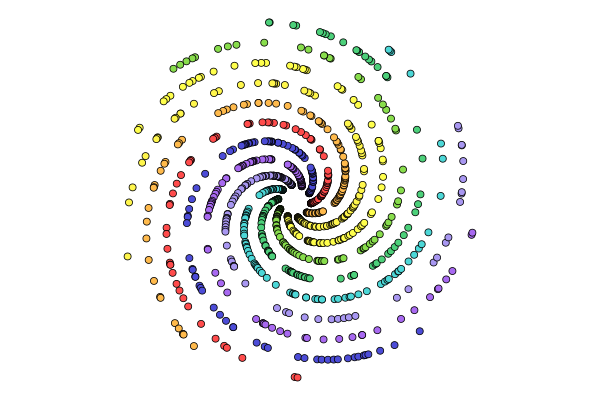

In [34]:
using Random
using Distributions
using LogExpFunctions
# arms = [1,1,1,1,1,5,5,5,5,5]
# arms = [1,5,1,5,1,5,1,5,1,5]
arms = ones(10)
@info "Entropy = $(-sum(xlogx.(arms)))"
@info arms
N = 1000
arms =  Int.(round.(arms./sum(arms) * N))
N = sum(arms)
K = length(arms)

X, T, labels_all = general_kSpiral(arms)

scatter(X[:, 1], X[:, 2], marker_z = labels_all, c = :lighttest, 
    ticks = nothing, leg=false,  grid=false, showaxis = false, aspect_ratio=1.0)
# savefig("../figs/spiral_data")

In [35]:
N

1000

In [36]:
using StatsBase

prop = 0.1

label_idx, labels = sample_labels( labels_all, prop)

ε = 1.0
γ_qot = QOT_weight(X, ε)

Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)

([0.9999999999999996 5.32247860851203e-9 … 5.32247860851203e-9 5.322478441621335e-9; 0.9999999999999994 5.32768467182228e-9 … 5.32768467182228e-9 5.327684453181891e-9; … ; 0.7655261794711831 -1.2704907093137293e-8 … -1.2704907093137293e-8 -1.2704907338085393e-8; 0.7658508348392153 -1.2588821483245252e-8 … -1.2588821483245252e-8 -1.2588821983874515e-8], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 1, 1])

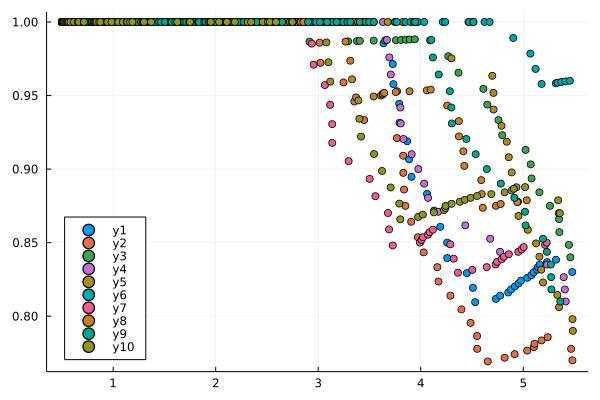

In [37]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infered_arm[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomleft)
end
display(fig)
# savefig("../figs/QOT_t_vs_acc")

In [38]:
c = distinguishable_colors(10, colorant"yellow")
# print(infer_label)
c[infer_label]


In [39]:
c[labels_all]

In [40]:
sum(labels_all .== infer_label) /N

0.84

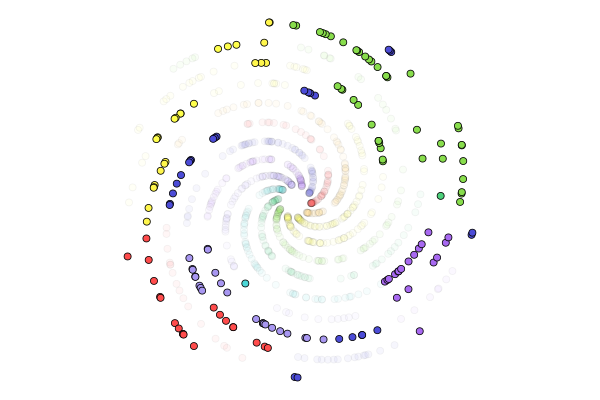

In [41]:
inds = infer_label .!= labels_all
r = 1:N
mislabel_qot = r[inds]


hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_qot, 1], X[mislabel_qot, 2], marker_z = infer_label[mislabel_qot], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

# savefig("../figures/Varying_density_spiral/QOT_infered925")
display(hd)


In [42]:

k = 5
γ_knn = kNN_Weight(X, k)

Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)

([0.997251502137966 6.747675179534123e-5 … 7.487722814304575e-6 0.0026552869699425267; 0.997251502137881 6.747675179724531e-5 … 7.487722814382562e-6 0.002655286970023281; … ; 0.4320376683340769 0.07417106769807025 … 0.0018890547445167799 0.04771783945431728; 0.43252528902246185 0.07417717269420765 … 0.0018857774077325337 0.04763196054843209], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 10, 10, 3, 3, 3, 1, 1])

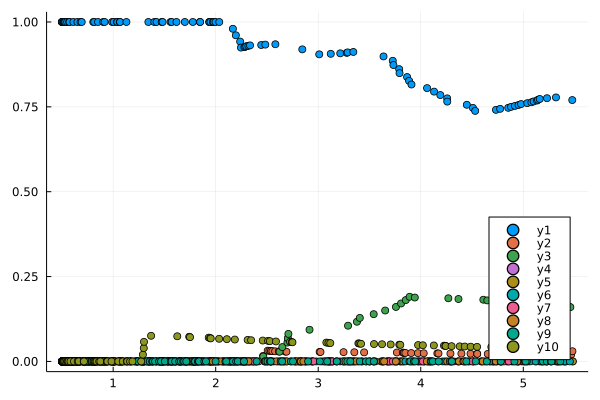

In [43]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label_knn[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infer_label_knn[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomright)
end
display(fig)
# savefig("../figures/Varying_density_spiral/KNN_t_vs_acc")

In [44]:
c[labels_all]

In [45]:
c[infer_label_knn]

In [46]:
sum(labels_all .== infer_label_knn) /N

0.775

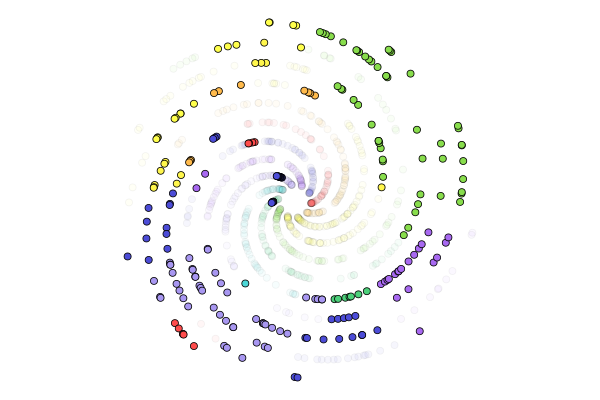

In [47]:
inds_knn = infer_label_knn .!= labels_all
r = 1:N
mislabel_knn = r[inds_knn]



hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label_knn, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_knn, 1], X[mislabel_knn, 2], marker_z = infer_label_knn[mislabel_knn], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)


display(hd)

# ew = makeEdgeWeights(γ_knn)

# G = LightGraphs.Graph(γ_knn+γ_knn')
# # gp_ew = gplot(G, X[:,1], -X[:,2], edgelinewidth=ew)
# gp = gplot(G, X[:,1], -X[:,2])

# # draw(PNG("../figures/Varying_density_spiral/QOT_graph.png", 16cm, 16cm), gp)

# display(gp)
# display(gp_ew)

In [63]:
eps_val = exp10.(-1:0.2:1)
knn_val = 4:14

4:14

In [64]:
length(eps_val)

11

In [73]:
eps_val = exp10.(-1:0.1:1)
knn_val = 3:18

Le = length(eps_val)
Lk = length(knn_val)

QOT_acc = zeros(5, Le)
KNN_acc = zeros(5, Lk)

param_num = 11

for i in 1:5
arms = ones(10)
@info "Entropy = $(-sum(xlogx.(arms)))"
@info arms
N = 1000 * i
arms =  Int.(round.(arms./sum(arms) * N))
N = sum(arms)
K = length(arms)

X, T, labels_all = general_kSpiral(arms)
prop = 0.1
label_idx, labels = sample_labels( labels_all, prop)

for j in 1:Le
    ε = eps_val[j]
    γ_qot = QOT_weight(X, ε)
    Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)
    QOT_acc[i, j] = sum(labels_all .== infer_label) /N
end
for j in 1:Lk
    k = knn_val[j]
    γ_knn = kNN_Weight(X, k, 1.0)
    Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)
    KNN_acc[i, j] = sum(labels_all .== infer_label_knn) /N
end
    
end

┌ Info: Entropy = -0.0
└ @ Main In[73]:14
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[73]:15
┌ Info: Entropy = -0.0
└ @ Main In[73]:14
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[73]:15
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (50/50): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/yRtwR/src/quadratic_newton_symm.jl:136
┌ Info: Entropy = -0.0
└ @ Main In[73]:14
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[73]:15
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (50/50): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/yRtwR/src/quadratic_newton_symm.jl:136
┌ Info: Entropy = -0.0
└ @ Main In[73]:14
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[73]:15
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float

In [69]:
QOT_acc

5×21 Matrix{Float64}:
 0.626     0.658     0.68      0.68      0.7       0.708     …  0.39      0.37      0.364     0.344     0.318     0.296
 0.714     0.738     0.758     0.775     0.781     0.796        0.647     0.559     0.488     0.476     0.436     0.419
 0.762667  0.796667  0.803333  0.834667  0.843333  0.862667     0.802667  0.702667  0.643333  0.551333  0.515333  0.462667
 0.828     0.8705    0.8585    0.879     0.9       0.9065       0.8405    0.8155    0.771     0.6835    0.5565    0.4725
 0.8668    0.8912    0.906     0.9188    0.9288    0.93         0.9036    0.8544    0.8156    0.7544    0.6724    0.592

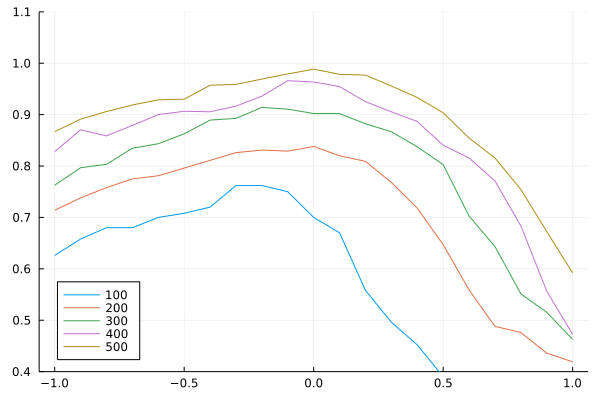

In [70]:
plot(log10.(eps_val), QOT_acc[1, :], ylims=(0.4, 1.1),
    label="100", legend=:bottomleft)
plot!(log10.(eps_val), QOT_acc[2, :], label="200")
plot!(log10.(eps_val), QOT_acc[3, :], label="300")
plot!(log10.(eps_val), QOT_acc[4, :], label="400")
plot!(log10.(eps_val), QOT_acc[5, :], label="500")

# savefig("../figs/ε_vs_acc")

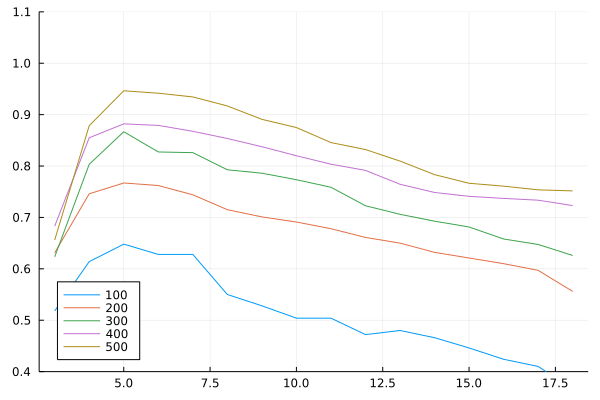

In [72]:
plot(knn_val, KNN_acc[1, :], ylims=(0.4, 1.1),
    label="100",legend=:bottomleft)
plot!(knn_val, KNN_acc[2, :], label="200")
plot!(knn_val, KNN_acc[3, :], label="300")
plot!(knn_val, KNN_acc[4, :], label="400")
plot!(knn_val, KNN_acc[5, :], label="500")
# savefig("../figs/k_vs_acc")

In [28]:
exp10.(-1:0.2:1)
collect(2:12)

11-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

In [29]:
sample_num = 10
param_num = 11
prop = 0.01

Entropy = zeros(sample_num)

QOT_acc = SharedArray{Float64}(sample_num, param_num)
KNN_acc = SharedArray{Float64}(sample_num, param_num)

@time for i in 1:sample_num
    N = 1000
    arms = rand(Dirichlet(*ones(10)))
    Entropy[i] = -sum(xlogx.(arms))
    
    arms =  Int.(round.(arms./sum(arms) * N))
    N = sum(arms)
    K = length(arms)

    X, T, labels_all = general_kSpiral(arms)
    label_idx, labels = sample_labels( labels_all, prop)

    for j in 1:param_num
        ε = eps_val[j]
        γ_qot = QOT_weight(X, ε)
        Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)
        QOT_acc[i, j] = sum(labels_all .== infer_label) /N

        k = knn_val[j]
        γ_knn = kNN_Weight(X, k, 1.0)
        Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)
        KNN_acc[i, j] = sum(labels_all .== infer_label_knn) /N
    end
end

LoadError: syntax: "*" is not a unary operator

In [ ]:
rmprocs(workers())

In [ ]:
p = sortperm(Entropy)




In [ ]:
ht = heatmap(Entropy[p], log10.(eps_val), QOT_acc[p,:]', clim=(0.0, 1.0),
        ylabel= "log(ϵ)", xlabel="Entropy", title="QOT Accuracy")

In [ ]:
ht = heatmap(Entropy[p], knn_val, KNN_acc[p,:]', clim=(0.0, 1.0),
        ylabel= "neighbours", xlabel="Entropy", title="KNN Accuracy")